In [ ]:
#Core libs
import climakitae as ck
from climakitae.core.data_interface import get_data
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import warnings

#GS libs
import rioxarray as rxr
import geopandas as gpd
try:
    # Import cartopy for projections and map features
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    print("rioxarray, geoPands, cartopy working")
except ImportError:
    print("Cartopy and others missing doubel check.")
    ccrs = None

warnings.filterwarnings("ignore", category=FutureWarning)
#DPI higher makes for better resolution figures (optional)
plt.rcParams['figure.dpi'] = 150
print("Setup complete.")

Geospatial libraries (rioxarray, geopandas, cartopy) imported.
Setup complete.


In [ ]:
#Average temp and total precipitation
VARIABLES = {
    "temp": "Air Temperature at 2m",
    "precip": "Precipitation (total)"
}

#Scenarios, historical and two future projections
SCENARIOS = ["Historical Climate", "SSP 3-7.0", "SSP 2-4.5"]
RESOLUTION = "3 km"
#Climatology Periods from the papers, i think these are traditional
CLIMATOLOGY_PERIODS = {
    "Baseline (1985-2014)": (1985, 2014), 
    "Mid-Century (2035-2064)": (2035, 2064), 
    "Late-Century (2070-2099)": (2070, 2099), }

#Need full time span for retrevia
TIME_SPAN = (1985, 2099)

# Fake JTree boundind box
latitude_slice = (33.5, 34.3)
longitude_slice = (-116.6, -115.4)
# extentw/ extra for plotting later
PLOT_EXTENT = [longitude_slice[0]-0.05, longitude_slice[1]+0.05,
               latitude_slice[0]-0.05, latitude_slice[1]+0.05]

In [ ]:
dataDoct = {}
for key, var_name in VARIABLES.items():
    try:
        data = get_data(
            variable=var_name,resolution=RESOLUTION,timescale="monthly",scenario=SCENARIOS,
            time_slice=TIME_SPAN,
            latitude=latitude_slice,
            longitude=longitude_slice
        )
        dataDoct[key] = data
    except Exception as e:
        print(f"Bug with key {key}: {e}")
if 'temp' in dataDoct:
    if dataDoct['temp'].attrs.get('units') == 'K':
        dataDoct['temp'] = dataDoct['temp'] - 273.15
        dataDoct['temp'].attrs['units'] = '°C'

if 'precip' in dataDoct:
    #For precipitation, need to look at MAP, resample monthly data to annaul sum, 
    #squeeze tirival dimens before resmple.
    
    dataDoct['precip_annual'] =dataDoct['precip'].squeeze().resample(time='YE').sum(dim='time')
    dataDoct['precip_annual'].attrs['units'] ='mm/year'


Starting data retrieval for 1985-2099...
Retrieving temp...
Retrieving precip...

Precipitation data resampled to annual totals.


In [ ]:
import numpy as np 
def calculate_climatologies(data_array, periods):
    """Gets 30 year climatologies for the periods decsribed in cell 1"""
    climatologies = {}
    
    if 'scenario' not in data_array.coords:
        print("Warning: 'scenario' coordinate missing.")
        return climatologies # Return empty if scenario coordinate is missing

    # Identify future scenarios
    # FIX: Use np.atleast_1d and to_numpy() to ensure the values are iterable 
    # even if the coordinate is scalar (0-d).
    all_scenarios = list(np.atleast_1d(data_array.scenario.to_numpy()))
    
    future_scenarios = [s for s in all_scenarios if s != "Historical Climate"]

    for name, (start, end) in periods.items():
        period_data = data_array.sel(time=slice(str(start), str(end)))
        climatology_mean = period_data.mean(dim='time')
        
        # Robustly get current scenarios present in the slice
        current_scenarios = list(np.atleast_1d(climatology_mean.scenario.to_numpy()))

        # Handle Scenarios:
        if start < 2015:
             # Baseline period
             scenario_to_select = None
             if "Historical Climate" in current_scenarios:
                 scenario_to_select = "Historical Climate"
             elif len(current_scenarios) > 0:
                # When historical+future are loaded together, historical data might be under SSP labels.
                # Select the first available scenario to represent the baseline.
                scenario_to_select = current_scenarios[0]
             
             if scenario_to_select:
                 # We want the baseline structure to be [simulation, y, x] (no scenario dimension).
                 
                 # Check if 'scenario' is a dimension before using .sel(..., drop=True)
                 if 'scenario' in climatology_mean.dims:
                    climatology_mean = climatology_mean.sel(scenario=scenario_to_select, drop=True)
                 else:
                    # If it's a scalar coordinate (already squeezed), we drop the coordinate variable 
                    # reference to ensure consistency.
                    climatology_mean = climatology_mean.drop_vars('scenario', errors='ignore')
             else:
                continue
        else:
            # Future periods
            available_future_scenarios = [s for s in future_scenarios if s in current_scenarios]
            
            if available_future_scenarios:
                # We want the future structure to be [scenario, simulation, y, x].
                
                # Check if 'scenario' is a dimension before using .sel()
                if 'scenario' in climatology_mean.dims:
                    climatology_mean = climatology_mean.sel(scenario=available_future_scenarios)
                else:
                    # If it's scalar (squeezed), it means only one scenario is present. 
                    # We expand the dimension back for consistency.
                    climatology_mean = climatology_mean.expand_dims(dim={'scenario': available_future_scenarios})
            else:
                 continue

        # Preserve attributes (like units)
        climatology_mean.attrs.update(data_array.attrs)
        climatologies[name] = climatology_mean
    
    return climatologies

# Calculate for both variables
climatologies_dict = {}
if 'temp' in dataDoct:
    print("Calculating temperature climatologies...")
    climatologies_dict['temp'] = calculate_climatologies(dataDoct['temp'], CLIMATOLOGY_PERIODS)

if 'precip_annual' in dataDoct:
    print("Calculating precipitation climatologies (MAP)...")
    climatologies_dict['precip'] = calculate_climatologies(dataDoct['precip_annual'], CLIMATOLOGY_PERIODS)

print("Climatology calculation complete.")

Calculating temperature climatologies...
Calculating precipitation climatologies (MAP)...
Climatology calculation complete.


In [ ]:
def calculate_anomalies_and_uncertainty(climatologies, carType):
    """Calculates anomalies and uncertainty statistics."""
    baseLineName=list(CLIMATOLOGY_PERIODS.keys())[0]
    baselineData=climatologies[baseLineName]
    futurePeriods= list(CLIMATOLOGY_PERIODS.keys())[1:]
    results ={}
    for period in futurePeriods:
        futureData = climatologies[period]
        #need to calculate anomaly (detla)
        if carType =='precip':
            #percentage change for precip
            epsil =1e-9 #(for div by zero error )
            anomalies = ((futureData - baselineData) /(baselineData +epsil)) * 100
            unit = '% Change'
        else:
            #abs change for temperature
            anomalies = ((futureData -baselineData))
            unit =f"Delta{baselineData.attrs.get('units', '°C')}"
    #get ensemble mean anomaly (signal)
        ensembleMeanAnolopy = anomalies.mean(dim='simulation')
        ensembleMeanAnolopy.attrs['units'] = unit

        #ensamble uncertainty has been described as standard deviation of anomalies
        ensembleUncertaintiy = anomalies.std(dim='simulation')
        ensembleUncertaintiy.attrs['units'] = unit
        results[period]= {
            'mean': ensembleMeanAnolopy,
            'uncertainty': ensembleUncertaintiy
        }
    return results

#calc for all
analysis_results = {}
if 'temp' in climatologies_dict:
    analysis_results['temp'] = calculate_anomalies_and_uncertainty(climatologies_dict['temp'], 'temp')
if 'precip' in climatologies_dict:
    analysis_results['precip'] = calculate_anomalies_and_uncertainty(climatologies_dict['precip'], 'precip')


Anomaly and uncertainty calculation complete.


Generating detailed custom map (Avenue 1: Cartopy + Matplotlib)...
Note: Preferred scenario 'SSP 3-7.0' not found for precipitation. Using 'Historical + SSP 3-7.0' instead.


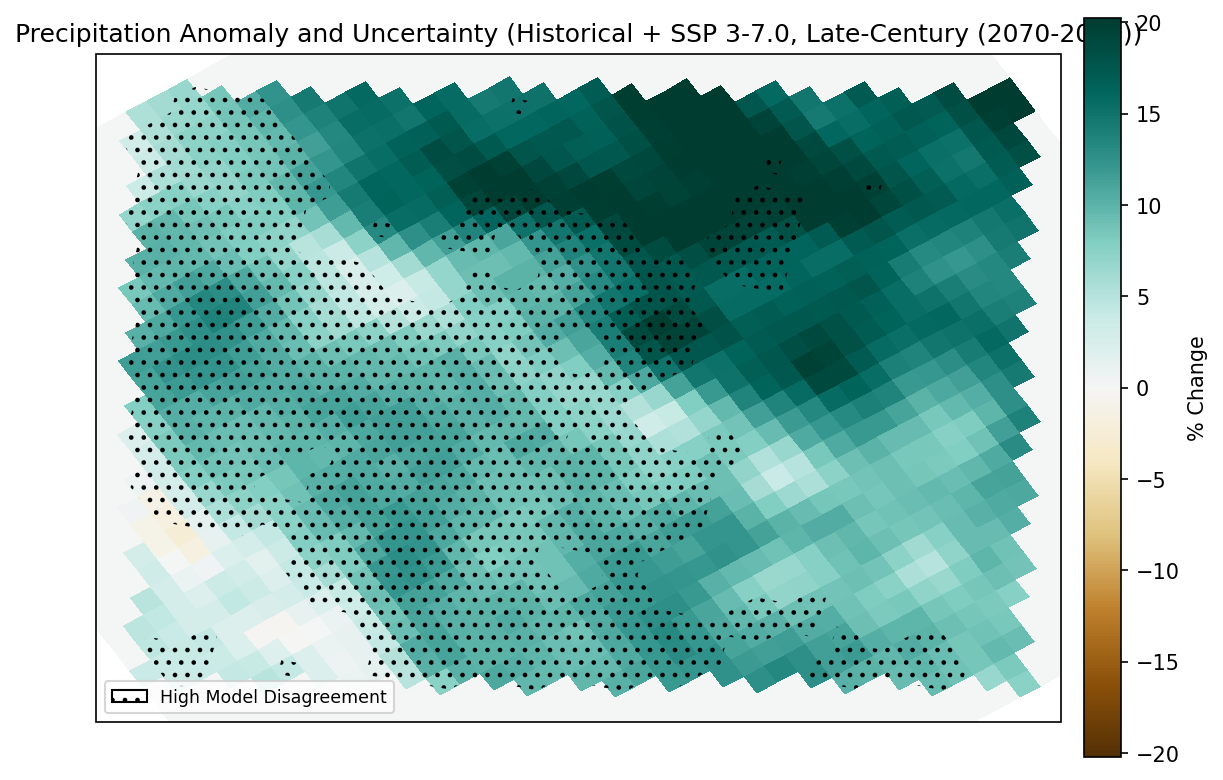

In [ ]:
#NOTE this took like 11 mins to run on my computer!!
import numpy as np
from matplotlib.patches import Patch

#cartop & matplotlib
if ccrs and 'precip' in analysis_results:
    period = 'Late-Century (2070-2099)'
    
    #Ugh defensive if the period calc was successful
    if period not in analysis_results['precip']:
        print(f"Can't get data for {period} w/in preceip results skipping plot, doubel chec what's up here.")
    else:
        #g3et data including all scnearios first
        meanDataAll = analysis_results['precip'][period]['mean']
        allUncertaintyData = analysis_results['precip'][period]['uncertainty']
        
        #np.atleast_1d to get an array even if scenario is scalar coodinate --> this repr as 0-d array
        allavailScenarios = list(np.atleast_1d(meanDataAll.scenario.to_numpy()))
        #check to see iff empty list or only holds NaN values
        if not allavailScenarios or all(pd.isnull(s) for s in allavailScenarios):
             print("go back and debug arrays, may be nan or empty.")
        else:
            #get scnario to focus on, and if not found just fallback--> helps me not screw up the name sand hten get a crash.
            prefScenario = "SSP 3-7.0"
            if prefScenario in allavailScenarios:
                focusingScnario = prefScenario
            else:
                #fallback, just use first scnario.
                focusingScnario = allavailScenarios[0]
                print(f"Btw didn't find '{prefScenario}'  for precipitation, on this run, using '{focusingScnario}' instead!")

            
            #get specific data, and check if scnario represetnted as dimension before using .sel to avoid silly bugg
            if 'scenario' in meanDataAll.dims:
                # If it's a dimension, we need to select the specific scenario.
                meanData = meanDataAll.sel(scenario=focusingScnario)
                uncertaintityData = allUncertaintyData.sel(scenario=focusingScnario)
            else:
                # If 'scenario' is not a dimension (scalar coordinate), it means only one scenario exists 
                # and the dimension was squeezed. The data is already focused on that scenario.
                meanData = meanDataAll
                uncertaintityData = allUncertaintyData

            # Plots
            
            # projection
            #I don't know much about this-- ask during meeting?
            projection = ccrs.PlateCarree()

            #figure and axis params
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(1, 1, 1, projection=projection)
            #plot mean data-->colour
            #diverging colourmap BrBG adn center at @ 0 via center = 0
            meshington = meanData.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=projection,
                cmap='BrBG', add_colorbar=False, robust=True, center=0)
            #overlay uncertainty (w/ hatching for disagreement, with thresh set as top quartile of std)
            thresh = uncertaintityData.quantile(0.75) #<- arbitrary
            highUncertaintyMas = uncertaintityData > thresh
             #MatPlotLib has countourf to add hatching where mask is True
            #Check if coords exist before acessing them
            if 'lon' in highUncertaintyMas.coords and 'lat' in highUncertaintyMas.coords:
                #acess underlying numpy values for countourf to work with 2d coords
                ax.contourf(
                    highUncertaintyMas.lon.values, highUncertaintyMas.lat.values, highUncertaintyMas.values,
                    levels=[0.5, 1.5], #levels to capture where mask true
                    colors='none',     #no colour fill only hatching
                    hatches=['..'],    # The hatching pattern #hatching pattern
                    transform=projection)
            else:
                print("lat long not found!")

            #Customise map
            #  globals() checkickng if cfeature was successfully imported in first cell 1
            if 'cfeature' in globals() and cfeature:
                try:
                    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
                except Exception as e:
                    #Note downstream error potential
                    print(f"cuodn't add STATES feature: {e}")

            #esnure plot extent defined 
            #if not should be a problem in cell 2
            try:
                ax.set_extent(PLOT_EXTENT)
            except NameError:
                #extent from the data itself as a fallback-- go back to cell 2 to see why wouldn't be defned though
                ax.set_extent([float(meanData.lon.min()), float(meanData.lon.max()), 
                               float(meanData.lat.min()), float(meanData.lat.max())])


            ax.set_title(f'Precipitation Anomaly and Uncertainty ({focusingScnario}, {period})')

            #Colour and legend stuff
            colourBar =plt.colorbar(meshington, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
            colourBar.set_label(meanData.attrs.get('units', '% Change'))
            l3gendEles = [Patch(facecolor='white', edgecolor='k', hatch='..', label='High Model Disagreement')]
            ax.legend(handles=l3gendEles, loc='lower left', fontsize='small')

            plt.show()
else:
    print("preccip or catopy not found")
#try to get one dot per pixel



Preparing data for vector visualization (Zonal Statistics)...
Note: Preferred scenario 'SSP 3-7.0' not found for temperature. Using 'Historical + SSP 3-7.0' instead.
Data CRS is PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",-70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]. Reprojecting Raster data to EPSG:4326...
Dropping 2D auxiliary coordinates (lat, lon, landmask, lakemask) before reprojection.
Raster reprojection complete.
Generating choropleth map (Avenue 2: GeoPandas + Matplotlib)...


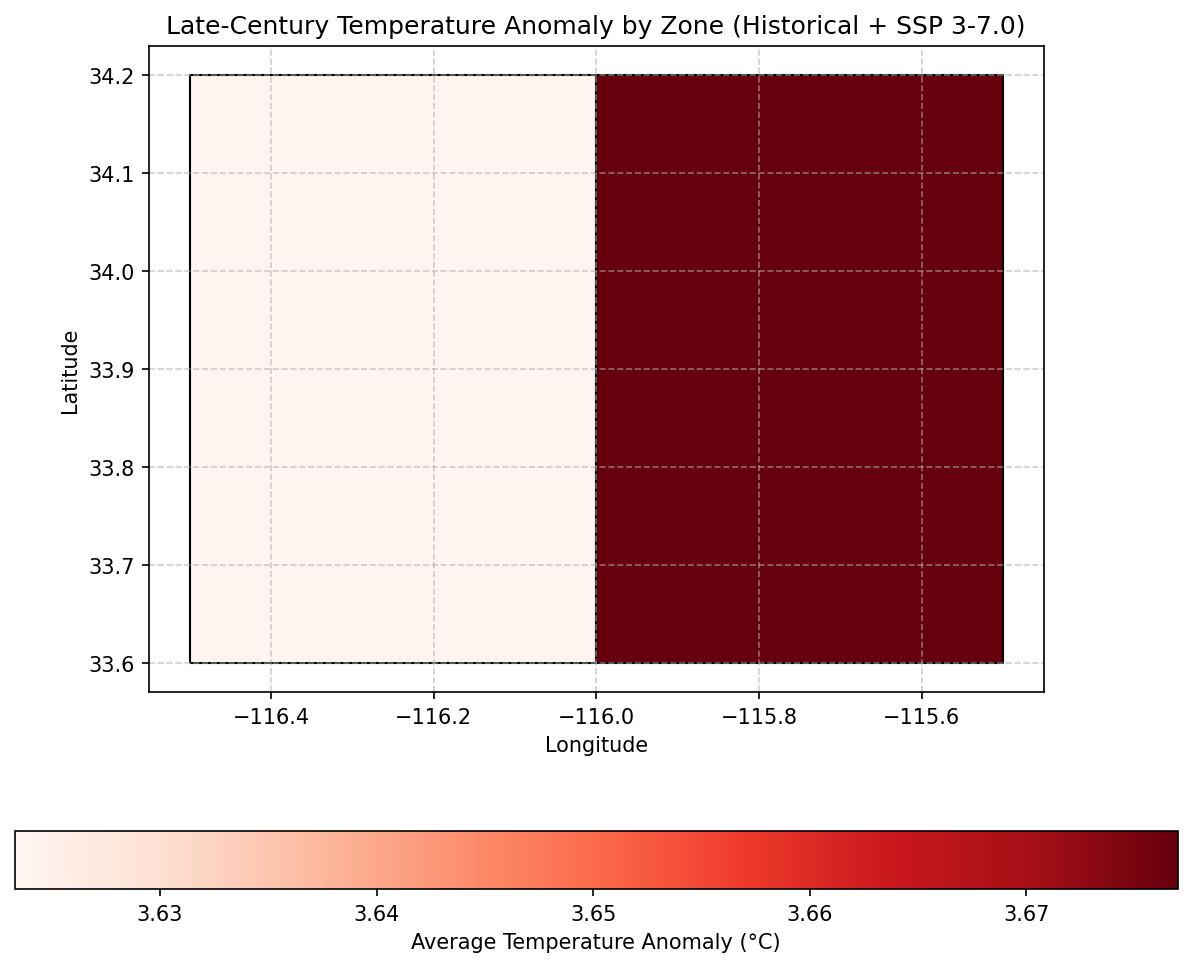

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr



STANDARD_CRS = "EPSG:4326"
polyA = Polygon([(-116.5, 33.6), (-116.5, 34.2), (-116.0, 34.2), (-116.0, 33.6), (-116.5, 33.6)])
polyB = Polygon([(-116.0, 33.6), (-116.0, 34.2), (-115.5, 34.2), (-115.5, 33.6), (-116.0, 33.6)])
zones_gdf = gpd.GeoDataFrame({'Zone': ['Zone A', 'Zone B']}, geometry=[polyA, polyB], crs=STANDARD_CRS)

period = 'Late-Century (2070-2099)'

if 'temp' in analysis_results and period in analysis_results['temp']:
    
    mean_data_all = analysis_results['temp'][period]['mean']
    raster_data = None 
    available_scenarios = list(np.atleast_1d(mean_data_all.scenario.to_numpy()))

    if not available_scenarios or all(pd.isnull(s) for s in available_scenarios):
         print("Error: No valid scenarios found for temperature data. Skipping plot.")
    else:
        preferred_scenario = "SSP 3-7.0"
        if preferred_scenario in available_scenarios:
            scenario_focus = preferred_scenario
        else:
            scenario_focus = available_scenarios[0]
            print(f"Note: Preferred scenario '{preferred_scenario}' not found for temperature. Using '{scenario_focus}' instead.")
        if 'scenario' in mean_data_all.dims:
            raster_data = mean_data_all.sel(scenario=scenario_focus)
        else:
            raster_data = mean_data_all
    if raster_data is not None:
        
        data_crs = raster_data.rio.crs
        raster_data_reprojected = None
        
        if data_crs is not None and str(data_crs) != STANDARD_CRS:
            print(f"Data CRS is {data_crs}. Reprojecting Raster data to {STANDARD_CRS}...")
            try:
                print("Dropping 2D auxiliary coordinates (lat, lon, landmask, lakemask) before reprojection.")
                coords_to_drop = ['lat', 'lon', 'landmask', 'lakemask']
                raster_data_cleaned = raster_data.drop_vars(coords_to_drop, errors='ignore')
                
                raster_data_reprojected = raster_data_cleaned.rio.reproject(STANDARD_CRS)
                print("Raster reprojection complete.")
                
            except Exception as e:
                print(f"Error during raster reprojection: {e}. Cannot perform zonal statistics.")
        else:
            raster_data_reprojected = raster_data
            if data_crs is None:
                print("Warning: Raster data is missing CRS information. Proceeding assuming WGS84.")


        zonal_means = []
        if raster_data_reprojected is not None:
            for i, geometry in enumerate(zones_gdf.geometry):
                try:
                    # Cli
                    clipped_data = raster_data_reprojected.rio.clip([geometry], drop=True, all_touched=True)
                    
                    if clipped_data.size == 0:
                        print(f"  Zone {i}: No overlap found after clipping.")
                        zonal_means.append(np.nan)
                        continue

                    non_spatial_dims = ['simulation', 'time', 'scenario', 'band']
                    spatial_dims = [dim for dim in clipped_data.dims if dim not in non_spatial_dims]
                    
                    mean_value = clipped_data.mean(dim=spatial_dims).item()
                    
                    if pd.isnull(mean_value):
                         print(f"  Zone {i}: Mean calculation resulted in NaN.")
                    
                    zonal_means.append(mean_value)

                except Exception as e:
                    print(f"  Zone {i}: Clipping failed. Error: {e}")
                    zonal_means.append(np.nan)

            zones_gdf['Temp_Anomaly_C'] = zonal_means
            
            print("Generating choropleth map (Avenue 2: GeoPandas + Matplotlib)...")
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))

            if zones_gdf['Temp_Anomaly_C'].isnull().all():
                print("Warning: All zonal statistics resulted in NaN. Check data CRS and overlap.")
            
            zones_gdf.plot(column='Temp_Anomaly_C', ax=ax, legend=True, cmap='Reds',
                           edgecolor='k', linewidth=1,
                           legend_kwds={'label': "Average Temperature Anomaly (°C)",
                                        'orientation': "horizontal"},
                           missing_kwds={"color": "lightgrey", "label": "Missing data"}) # Style for NaNs


            # Formatting
            ax.set_title(f'Late-Century Temperature Anomaly by Zone ({scenario_focus})')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
        else:

else:
